In [1]:
import numpy as np
import pandas as pd


In [4]:
dataset=pd.read_csv(r"C:\Users\Samsung\Downloads\archive (16)\Fertilizer Prediction.csv")
dataset["Crop Type"].unique()

array(['Maize', 'Sugarcane', 'Cotton', 'Tobacco', 'Paddy', 'Barley',
       'Wheat', 'Millets', 'Oil seeds', 'Pulses', 'Ground Nuts'],
      dtype=object)

In [5]:
dataset

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,Sandy,Maize,37,0,0,Urea
1,29,52,45,Loamy,Sugarcane,12,0,36,DAP
2,34,65,62,Black,Cotton,7,9,30,14-35-14
3,32,62,34,Red,Tobacco,22,0,20,28-28
4,28,54,46,Clayey,Paddy,35,0,0,Urea
...,...,...,...,...,...,...,...,...,...
94,25,50,32,Clayey,Pulses,24,0,19,28-28
95,30,60,27,Red,Tobacco,4,17,17,10-26-26
96,38,72,51,Loamy,Wheat,39,0,0,Urea
97,36,60,43,Sandy,Millets,15,0,41,DAP


In [6]:
dataset.isnull().sum()

Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

In [16]:
dataset['Fertilizer Name'].unique()

array(['Urea', 'DAP', '14-35-14', '28-28', '17-17-17', '20-20',
       '10-26-26'], dtype=object)

Test Accuracy: 1.0
              precision    recall  f1-score   support

    10-26-26       1.00      1.00      1.00         1
    14-35-14       1.00      1.00      1.00         3
    17-17-17       1.00      1.00      1.00         1
       20-20       1.00      1.00      1.00         3
       28-28       1.00      1.00      1.00         3
         DAP       1.00      1.00      1.00         4
        Urea       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



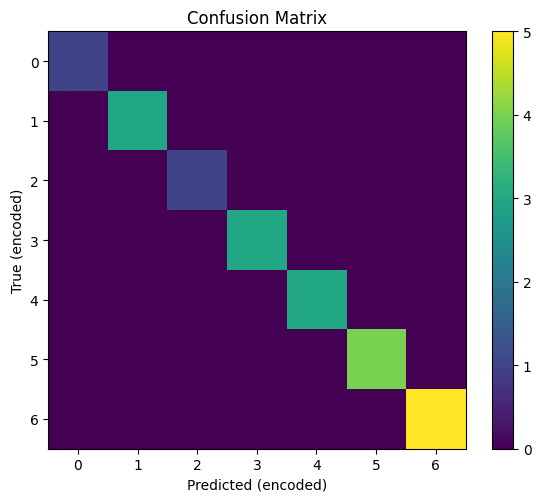

Top features:
 Phosphorous            0.305030
Nitrogen               0.242662
Potassium              0.133066
Moisture               0.071400
Temparature            0.054299
Humidity               0.050242
Crop Type=Sugarcane    0.013680
Soil Type=Red          0.013664
Soil Type=Loamy        0.012334
Soil Type=Black        0.012156
dtype: float64
Saved model


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import joblib
import matplotlib.pyplot as plt


file_path = r"C:\Users\Samsung\Downloads\archive (16)\Fertilizer Prediction.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip() 

def find_col(cols, keyword):
    for c in cols:
        if keyword.lower() in c.lower():
            return c
    return None

temp_col = find_col(df.columns, "temp") or "Temparature"
humidity_col = find_col(df.columns, "humid") or "Humidity"
moisture_col = find_col(df.columns, "moist") or "Moisture"
soil_col = find_col(df.columns, "soil") or "Soil Type"
crop_col = find_col(df.columns, "crop") or "Crop Type"
nitro_col = find_col(df.columns, "nitro") or "Nitrogen"
pot_col = find_col(df.columns, "potas") or "Potassium"
phos_col = find_col(df.columns, "phos") or "Phosphorous"
target_col = find_col(df.columns, "fertil") or "Fertilizer Name"

expected = [temp_col, humidity_col, moisture_col, soil_col, crop_col, nitro_col, pot_col, phos_col, target_col]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")


for col in [soil_col, crop_col, target_col]:
    df[col] = df[col].astype(str).str.strip()


num_cols = [temp_col, humidity_col, moisture_col, nitro_col, pot_col, phos_col]
df_dummies = pd.get_dummies(df[[soil_col, crop_col]], prefix_sep="=")
X = pd.concat([df[num_cols].reset_index(drop=True), df_dummies.reset_index(drop=True)], axis=1)

le = LabelEncoder()
y = le.fit_transform(df[target_col])

feature_columns = X.columns.tolist()  


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print(metrics.classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted (encoded)")
plt.ylabel("True (encoded)")
plt.colorbar()
plt.tight_layout()
plt.show()


importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features:\n", importances.head(10))


joblib.dump(model, "fertilizer_model.joblib")
joblib.dump(le, "fert_label_encoder.joblib")
joblib.dump(feature_columns, "feature_columns.joblib")
print("Saved model")


In [ ]:
import pandas as pd
import joblib

model = joblib.load("fertilizer_model.joblib")
le = joblib.load("fert_label_encoder.joblib")
feature_columns = joblib.load("feature_columns.joblib")

def prepare_and_predict(sample: dict):

    num_cols = [c for c in feature_columns if c.split('=')[0] not in ['Soil Type', 'Crop Type']][:6]  
    sample_df = pd.DataFrame([sample])
    sample_dummies = pd.get_dummies(sample_df[[ 'Soil Type', 'Crop Type' ]], prefix_sep="=")
    sample_X = pd.concat([sample_df[num_cols].reset_index(drop=True), sample_dummies.reset_index(drop=True)], axis=1)
    for c in feature_columns:
        if c not in sample_X.columns:
            sample_X[c] = 0
    sample_X = sample_X[feature_columns]
    pred_enc = model.predict(sample_X)[0]
    return le.inverse_transform([pred_enc])[0]

example = {
 'Temparature': 30,
 'Humidity': 55,
 'Moisture': 45,
 'Soil Type': 'Loamy',
 'Crop Type': 'Maize',
 'Nitrogen': 20,
 'Potassium': 5,
 'Phosphorous': 10
}
print("Predicted fertilizer:", prepare_and_predict(example))


Predicted fertilizer: 28-28


In [14]:
import joblib

# Assuming 'model' is your trained model
joblib.dump(model, 'fertilizer_model.pkl')


['fertilizer_model.pkl']